In [2]:
# from pyspark import SparkContext 
# from pyspark.sql import SQLContext 
# import pandas as pd
# import numpy as np
# from pandas import DataFrame
# sc = SparkContext.getOrCreate()
# sqlc=SQLContext(sc)

import math
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy 
from scipy.stats import probplot
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Perceptron

In [3]:
#reading csv file data in a dataframe
#[1]https://stackoverflow.com/questions/46311133/creating-dynamic-data-frames-in-python?rq=1
df_names=['df07','df08','df09','df10','df11','df12','df13','df14','df15','df16','df17','df18']
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
d = {}
for name,i in zip(df_names,years):
    d[name] = pd.DataFrame()
    d[name]=pd.read_csv('data-csv/chs'+str(i)+'_public.csv')    


In [4]:
# df=df18.copy()
df=d['df16']
df.head()

,mood63,mood64,mood54,mood55,mood56,mood57,mood58,mood59,mood60,mood61,...,drivefreq,drivefreq_all,drivefreq3_all,everspeed,speedfreq,strata,hhsize,child,otherbcnotcondom2,bthcntrltype
0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,3.0,4.0,2.0,1.0,2.0,13,1,2.0,NaN,NaN
1,3.0,2.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,...,NaN,1.0,1.0,NaN,NaN,11,2,2.0,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,5,3,2.0,NaN,NaN
3,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,15,1,2.0,NaN,NaN
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,6,4,1.0,2.0,1.0


In [5]:
#number of features
len(df.columns)

147

In [6]:
df.columns

Index(['mood63', 'mood64', 'mood54', 'mood55', 'mood56', 'mood57', 'mood58',
       'mood59', 'mood60', 'mood61',
       ...
       'drivefreq', 'drivefreq_all', 'drivefreq3_all', 'everspeed',
       'speedfreq', 'strata', 'hhsize', 'child', 'otherbcnotcondom2',
       'bthcntrltype'],
      dtype='object', length=147)

In [7]:
#number of rows
len(df["mood63"])

10000

In [8]:
df.isnull().sum()

mood63                215
mood64                131
mood54                129
mood55                143
mood56                110
                     ... 
strata                  0
hhsize                  0
child                  48
otherbcnotcondom2    6259
bthcntrltype         6272
Length: 147, dtype: int64

qxvers-Questionnaire version
nutrition46-cupsof fruit
nutrition47-cups of vegetable

# Steps followed for analysis
#process NA values
#find correlation between target and source variables and perform dimensionality reduction
#divide data into training and test sets
#apply regression
#reduce parameters depending upon correlartion
#apply regression again and compare models

In [9]:
#correlation function
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#[2]https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def draw_corr(corr_var):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_var, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        corr_var, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask,
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# Checking correlation between physical activity data

In [10]:
df_train_physical=df[["cid","exercise16","generalhealth"]]

In [11]:
df_train_physical.isnull().sum()

cid               0
exercise16       19
generalhealth    89
dtype: int64

In [12]:
# #since imputed_PA08_3R_q1 has 5000+ values as N/A we will drop this column
# df_train_physical=df_train_physical[["cid","exercise116","cyclingfreq","cycling17","generalhealth"]]
# df_train_physical.head()

In [13]:
#dropping NaN values
df_train_physical=df_train_physical.dropna()
df_train_physical.head()

,cid,exercise16,generalhealth
0,1700001,2.0,2.0
1,1700002,1.0,5.0
2,1700003,1.0,1.0
3,1700004,2.0,3.0
4,1700005,1.0,1.0


In [14]:
#correlation
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr_1 = df_train_physical.corr()
corr_1

,cid,exercise16,generalhealth
cid,1.000000,-0.031687,-0.090365
exercise16,-0.031687,1.000000,0.209173
generalhealth,-0.090365,0.209173,1.000000


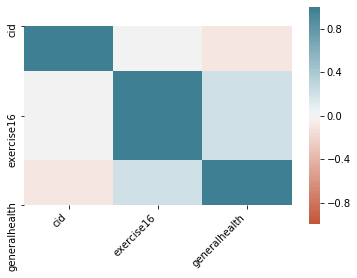

In [15]:
ax = sns.heatmap(
    corr_1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#we see that there is not much correlation among variables

In [16]:
# df_train_physical=df_train_physical[["cid","exercise17","cyclingfreq","generalhealth"]]
# df_train_physical.head()

In [17]:
# corr_2 = df_train_physical[["exercise17","cyclingfreq","generalhealth"]].corr()
# draw_corr(corr_2)
# print(corr_2)
# #All have positive correlation. exercise18 is most correlated to general health

# Checking correlation between Nutrition data

In [18]:
df_train_nutrition = df[["fruitveg",
                         "nsodaperday16","avgsodaperday16","twoplussoda",
                         "nsugardrinkperday16","avgsugarperday16","nsodasugarperday16",
                         "ssb",
                         "generalhealth"]]
print(df_train_nutrition.head())
df_train_nutrition.isnull().sum()


   fruitveg  nsodaperday16  avgsodaperday16  twoplussoda  nsugardrinkperday16  \
0       2.0            0.0              1.0          2.0             0.000000   
1       2.0            0.0              1.0          2.0             0.000000   
2       2.0            0.0              1.0          2.0             0.099174   
3       2.0            0.0              1.0          2.0             0.000000   
4       2.0            0.0              1.0          2.0             0.000000   

   avgsugarperday16  nsodasugarperday16  ssb  generalhealth  
0               1.0            0.000000  2.0            2.0  
1               1.0            0.000000  2.0            5.0  
2               2.0            0.099174  2.0            1.0  
3               1.0            0.000000  2.0            3.0  
4               1.0            0.000000  2.0            1.0  


fruitveg               256
nsodaperday16           64
avgsodaperday16         64
twoplussoda             64
nsugardrinkperday16     85
avgsugarperday16        85
nsodasugarperday16      90
ssb                     90
generalhealth           89
dtype: int64

nsodaperday16     generalhealth       0.002369
generalhealth     nsodaperday16       0.002369
                  avgsugarperday16    0.002841
avgsugarperday16  generalhealth       0.002841
twoplussoda       generalhealth       0.004716
                                        ...   
                  twoplussoda         1.000000
avgsodaperday16   avgsodaperday16     1.000000
nsodaperday16     nsodaperday16       1.000000
ssb               ssb                 1.000000
generalhealth     generalhealth       1.000000
Length: 81, dtype: float64

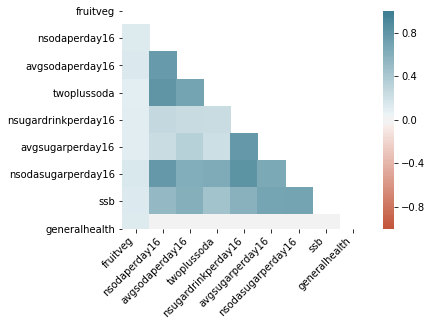

In [19]:
#[1]https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

df_train_nutrition=df_train_nutrition.dropna()
corr_3 = df_train_nutrition.corr().abs()
draw_corr(corr_3)

corr_3.unstack().sort_values(kind="quicksort")


generalhealth       avgsugarperday16      0.002841
avgsugarperday16    generalhealth         0.002841
generalhealth       nsodasugarperday16    0.018288
nsodasugarperday16  generalhealth         0.018288
generalhealth       avgsodaperday16       0.028963
avgsodaperday16     generalhealth         0.028963
ssb                 generalhealth         0.031958
generalhealth       ssb                   0.031958
avgsodaperday16     avgsugarperday16      0.328768
avgsugarperday16    avgsodaperday16       0.328768
ssb                 avgsodaperday16       0.604296
avgsodaperday16     ssb                   0.604296
nsodasugarperday16  avgsodaperday16       0.624161
avgsodaperday16     nsodasugarperday16    0.624161
avgsugarperday16    nsodasugarperday16    0.655347
nsodasugarperday16  avgsugarperday16      0.655347
ssb                 avgsugarperday16      0.694780
avgsugarperday16    ssb                   0.694780
ssb                 nsodasugarperday16    0.696780
nsodasugarperday16  ssb        

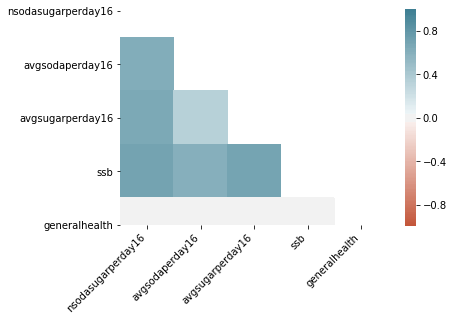

In [20]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nsodasugarperday16",
                        "avgsodaperday16"
                        ,"avgsugarperday16"
                         ,"ssb"
                         ,"generalhealth"]]

#finding correlation in remaining features
corr_nutrition = df_train_nutrition.corr().abs()
draw_corr(corr_nutrition)
corr_nutrition.unstack().sort_values(kind="quicksort")


#Next most correlated columns after deleting the previous coulmns:

nutrition47       fruitveg18          0.597664
fruitveg18        nutrition46         0.624137
avgsodaperday18   ssb                 0.626788

ssb               avgsugarperday18   -0.687271

ssb is correlated to both avgsodaperday18 and avgsugarperday18. We will keep ssb as it combines both soda and other drinks consumed by an individual. Also nutrition47 and fruitveg18 are correlated. Lets keep them for now as corelation is not very strong.

In [21]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[[
                         "ssb"
                         ,"generalhealth"]]

# Making prediction and checking rmse

In [22]:
#[1]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#[2]https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#[3]https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#[4]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from math import sqrt

#function for rmse calculation of model
def model_apply(x,y,algo,n):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x_train)
    # Apply transform to both the training set and the test set.
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=n,tol=.95)
    pca.fit(x_test)
    print(pca.explained_variance_ratio_) 
    
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
#     principalDf = pd.DataFrame(data = x_train
#              , columns = ['pc1', 'pc2','pc3'])
#     print(principalDf)

    #model selection
    if algo==1:
        model=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=200)
    elif algo==2:
        model=GaussianNB()
    elif algo==3:
        model=DecisionTreeClassifier()
    elif algo==4:
        model=svm.SVC(gamma='scale')
    elif algo==5:
        model=Perceptron(tol=1e-3, random_state=0)
        
        # Train the model using the training sets
    model.fit(x_train,y_train.values.ravel())

    # Predict Output
    y_pred = model.predict(x_test)
    print ("Predicted Value:", y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

# Physical Activity vs General Health

In [23]:
#preparing training and test data
x=df_train_physical[["exercise16"]] #source feature
y=df_train_physical[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1660
# model = GaussianNB() #rmse=1.28

In [25]:
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3234937323089365
[[  0   0 405   0   0]
 [  0   0 639   0   0]
 [  0   0 800   0   0]
 [  0   0 471   0   0]
 [  0   0 158   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       405
         2.0       0.00      0.00      0.00       639
         3.0       0.32      1.00      0.49       800
         4.0       0.00      0.00      0.00       471
         5.0       0.00      0.00      0.00       158

    accuracy                           0.32      2473
   macro avg       0.06      0.20      0.10      2473
weighted avg       0.10      0.32      0.16      2473



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1659684429813295

# Nutrition vs General Health

In [27]:
#preparing training and test data
x=df_train_nutrition[["ssb"]] #source feature
y=df_train_nutrition[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.16379
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3192291579388354
[[  0   0 363   0   0]
 [  0   0 623   0   0]
 [  0   0 762   0   0]
 [  0   0 466   0   0]
 [  0   0 173   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       363
         2.0       0.00      0.00      0.00       623
         3.0       0.32      1.00      0.48       762
         4.0       0.00      0.00      0.00       466
         5.0       0.00      0.00      0.00       173

    accuracy                           0.32      2387
   macro avg       0.06      0.20      0.10      2387
weighted avg       0.10      0.32      0.15      2387



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.163795417491671

# Checking correlation between CardioVascular Health data

In [28]:
df_train_cardio=df[["toldhighbp16","toldprescription16","takingmeds16","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp16  toldprescription16  takingmeds16  generalhealth
0           1.0                 1.0           1.0            2.0
1           1.0                 1.0           1.0            5.0
2           2.0                 NaN           NaN            1.0
3           1.0                 1.0           1.0            3.0
4           1.0                 1.0           1.0            1.0


toldhighbp16            36
toldprescription16    6486
takingmeds16          6820
generalhealth           89
dtype: int64

toldprescription16 and takingmeds16 has high NA values so we have to drop them from dataset

In [29]:
df_train_cardio=df[["toldhighbp16","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp16  generalhealth
0           1.0            2.0
1           1.0            5.0
2           2.0            1.0
3           1.0            3.0
4           1.0            1.0


toldhighbp16     36
generalhealth    89
dtype: int64

toldhighbp16   generalhealth    0.32247
generalhealth  toldhighbp16     0.32247
toldhighbp16   toldhighbp16     1.00000
generalhealth  generalhealth    1.00000
dtype: float64

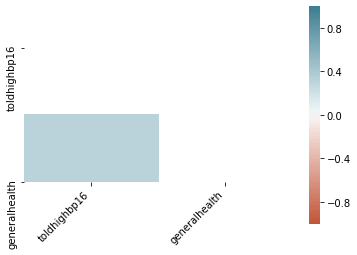

In [30]:
df_train_cardio=df_train_cardio.dropna()
corr_cardio = df_train_cardio.corr().abs()
draw_corr(corr_cardio)
corr_cardio.unstack().sort_values(kind="quicksort")

# Cardio vs General Health


In [32]:
df_train_cardio=df_train_cardio[["toldhighbp16","generalhealth"]]
df_train_cardio=df_train_cardio.dropna()
#preparing training and test data
x=df_train_cardio[["toldhighbp16"]] #source feature
y=df_train_cardio[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1836
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3230769230769231
[[  0   0 399   0   0]
 [  0   0 631   0   0]
 [  0   0 798   0   0]
 [  0   0 445   0   0]
 [  0   0 197   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       399
         2.0       0.00      0.00      0.00       631
         3.0       0.32      1.00      0.49       798
         4.0       0.00      0.00      0.00       445
         5.0       0.00      0.00      0.00       197

    accuracy                           0.32      2470
   macro avg       0.06      0.20      0.10      2470
weighted avg       0.10      0.32      0.16      2470



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1835580748738908

# Checking correlation between Diabetes data

In [33]:
df_train_diabetes=df[["diabetes16","generalhealth"]]
print(df_train_diabetes.head())
df_train_diabetes.isnull().sum()

   diabetes16  generalhealth
0         1.0            2.0
1         2.0            5.0
2         2.0            1.0
3         1.0            3.0
4         2.0            1.0


diabetes16       34
generalhealth    89
dtype: int64

Since only one column is there is no need to check correlation here.

# Diabetes vs General Health 

In [35]:
df_train_diabetes=df_train_diabetes[["diabetes16","generalhealth"]]
df_train_diabetes=df_train_diabetes.dropna()
#preparing training and test data
x=df_train_diabetes[["diabetes16"]] #source feature
y=df_train_diabetes[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1815
# algo=svm.SVC(gamma='scale') #emse=1.1714
# algo = GaussianNB() #rmse=1.2356
algo=DecisionTreeClassifier() #rmse=1.1714
model_apply(x,y,3,1)

[1.]
Predicted Value: [4. 3. 4. ... 3. 3. 4.]
Accuracy: 0.3129554655870445
[[  0   0 384  16   0]
 [  0   0 617  40   0]
 [  0   0 649 113   0]
 [  0   0 345 124   0]
 [  0   0 117  65   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       400
         2.0       0.00      0.00      0.00       657
         3.0       0.31      0.85      0.45       762
         4.0       0.35      0.26      0.30       469
         5.0       0.00      0.00      0.00       182

    accuracy                           0.31      2470
   macro avg       0.13      0.22      0.15      2470
weighted avg       0.16      0.31      0.20      2470



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1815038793859496

# Clubbing the different parameters

In [50]:
#df_train_physical[["exercise17","cyclingfreq","generalhealth"]]
#df_train_diabetes[["diabetes17","generalhealth"]]
#df_train_cardio[["toldhighbp17","generalhealth"]]
#df_train_nutrition[["nutrition46","nutrition47","ssb"]]
df_clubbed=df[["cid","exercise16","ssb",
              "diabetes16","toldhighbp16","generalhealth"]]
print(df_clubbed.head())
df_clubbed.isnull().sum()

       cid  exercise16  ssb  diabetes16  toldhighbp16  generalhealth
0  1700001         2.0  2.0         1.0           1.0            2.0
1  1700002         1.0  2.0         2.0           1.0            5.0
2  1700003         1.0  2.0         2.0           2.0            1.0
3  1700004         2.0  2.0         1.0           1.0            3.0
4  1700005         1.0  2.0         2.0           1.0            1.0


cid               0
exercise16       19
ssb              90
diabetes16       34
toldhighbp16     36
generalhealth    89
dtype: int64

In [93]:
df_clubbed=df_clubbed.dropna()
#preparing training and test data
x=df_clubbed.drop(columns=["cid","generalhealth"]) #source feature
y=df_clubbed[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1939
# algo=svm.SVC(gamma='scale') #emse=1.1607
# algo = GaussianNB() #rmse=1.2136
# algo=DecisionTreeClassifier() #rmse=1.4525
model_apply(x,y,1,3)

[0.33918907 0.27288066 0.2184046 ]
Predicted Value: [3. 3. 2. ... 3. 3. 3.]
Accuracy: 0.34372436423297786
[[  0 246 149   8   0]
 [  0 300 287  32   0]
 [  0 236 454  91   0]
 [  0  80 268  84   0]
 [  0  18 103  82   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       403
         2.0       0.34      0.48      0.40       619
         3.0       0.36      0.58      0.44       781
         4.0       0.28      0.19      0.23       432
         5.0       0.00      0.00      0.00       203

    accuracy                           0.34      2438
   macro avg       0.20      0.25      0.22      2438
weighted avg       0.25      0.34      0.28      2438



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.0906418247196132

# Physical Activity vs Cardio Health

In [64]:
#preparing training and test data
x=df_clubbed[["exercise16"]] #source feature
y=df_clubbed[["toldhighbp16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5929
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6484823625922888
[[   0  857]
 [   0 1581]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       857
         2.0       0.65      1.00      0.79      1581

    accuracy                           0.65      2438
   macro avg       0.32      0.50      0.39      2438
weighted avg       0.42      0.65      0.51      2438



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5928892286150181

# Nutrition vs Cardio Health

In [66]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["toldhighbp16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5929
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6484823625922888
[[   0  857]
 [   0 1581]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       857
         2.0       0.65      1.00      0.79      1581

    accuracy                           0.65      2438
   macro avg       0.32      0.50      0.39      2438
weighted avg       0.42      0.65      0.51      2438



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5928892286150181

# Physical vs Diabetes

In [69]:
#preparing training and test data
x=df_clubbed[["exercise16"]] #source feature
y=df_clubbed[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3900
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8482362592288761
[[   0  370]
 [   0 2068]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       370
         2.0       0.85      1.00      0.92      2068

    accuracy                           0.85      2438
   macro avg       0.42      0.50      0.46      2438
weighted avg       0.72      0.85      0.78      2438



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.38956865989337985

# Nutrition vs Diabetes

In [71]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3900
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8482362592288761
[[   0  370]
 [   0 2068]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       370
         2.0       0.85      1.00      0.92      2068

    accuracy                           0.85      2438
   macro avg       0.42      0.50      0.46      2438
weighted avg       0.72      0.85      0.78      2438



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.38956865989337985

We observed that most of the Diabetes predictions are of class 2. Probably there is an imbalace of class in test data. Let us check.

# Resampling Diabetese Dataset

In [72]:
#[1]https://elitedatascience.com/imbalanced-classes
df_clubbed["diabetes16"].value_counts()

2.0    8313
1.0    1439
Name: diabetes16, dtype: int64

As we can see that class 2 has more samples than class 1 which shows that data is impbalanced and fovours class 2. Upsampling the class 1 data :

# Up Sampling

In [73]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_clubbed[df_clubbed.diabetes16==2]
df_minority = df_clubbed[df_clubbed.diabetes16==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8313,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes16.value_counts()

1.0    8313
2.0    8313
Name: diabetes16, dtype: int64

# Nutrition vs Diabetes again after upsampling

In [75]:
#preparing training and test data
x=df_upsampled[["ssb"]] #source feature
y=df_upsampled[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6794
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [1. 1. 1. ... 1. 2. 1.]
Accuracy: 0.5383690161173923
[[1792  309]
 [1610  446]]
              precision    recall  f1-score   support

         1.0       0.53      0.85      0.65      2101
         2.0       0.59      0.22      0.32      2056

    accuracy                           0.54      4157
   macro avg       0.56      0.53      0.48      4157
weighted avg       0.56      0.54      0.49      4157



0.6794343116759762

# Physical Activity vs Diabetes after upsampling

In [77]:
#preparing training and test data
x=df_upsampled[["exercise16"]] #source feature
y=df_upsampled[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6759
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 2. 2. ... 1. 2. 2.]
Accuracy: 0.5431801780129901
[[ 768 1333]
 [ 566 1490]]
              precision    recall  f1-score   support

         1.0       0.58      0.37      0.45      2101
         2.0       0.53      0.72      0.61      2056

    accuracy                           0.54      4157
   macro avg       0.55      0.55      0.53      4157
weighted avg       0.55      0.54      0.53      4157



0.6758844738466847

# Down Sampling

In [78]:
#Down Sampling
df_majority = df_clubbed[df_clubbed.diabetes16==2]
df_minority = df_clubbed[df_clubbed.diabetes16==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1493,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.diabetes16.value_counts()

2.0    1493
1.0    1439
Name: diabetes16, dtype: int64

# Nutrition vs Diabetes again after down sampling

In [80]:
#preparing training and test data
x=df_downsampled[["ssb"]] #source feature
y=df_downsampled[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.7028
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 2. 1. 1. 2. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 2. 1. 2. 1. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2. 1.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1

0.7027523360608755

# Physical Activity vs Diabetes after down sampling

In [82]:
#preparing training and test data
x=df_downsampled[["exercise16"]] #source feature
y=df_downsampled[["diabetes16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6482
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [1. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 1. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2.
 2. 1. 2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 1. 2. 1. 2.
 2. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1.
 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 1. 2. 1. 2. 1. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2.
 1. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 1. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1.
 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 1. 2. 2.
 2. 1. 2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2.
 1. 1. 2. 1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2.
 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 2. 1. 2. 2. 2. 1. 2. 2. 1. 2

0.6482214096334913

After both Up and Down sampling the rmse is near about remains 0.66

# Marital Status vs Cardio Vascular Health

In [83]:
df_martial=df[["maritalstatus16","toldhighbp16","generalhealth"]]
df_martial=df_martial.dropna()

In [84]:
#preparing training and test data
x=df_martial[["maritalstatus16"]] #source feature
y=df_martial[["toldhighbp16"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

[1.]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6578086672117743
[[   0  837]
 [   0 1609]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       837
         2.0       0.66      1.00      0.79      1609

    accuracy                           0.66      2446
   macro avg       0.33      0.50      0.40      2446
weighted avg       0.43      0.66      0.52      2446



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.584971223897574

# Marital Status vs General Health Status

In [86]:
#preparing training and test data
x=df_martial[["maritalstatus16"]] #source feature
y=df_martial[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3250204415372036
[[  0   0 407   0   0]
 [  0   0 626   0   0]
 [  0   0 795   0   0]
 [  0   0 436   0   0]
 [  0   0 182   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       407
         2.0       0.00      0.00      0.00       626
         3.0       0.33      1.00      0.49       795
         4.0       0.00      0.00      0.00       436
         5.0       0.00      0.00      0.00       182

    accuracy                           0.33      2446
   macro avg       0.07      0.20      0.10      2446
weighted avg       0.11      0.33      0.16      2446



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1821097593869783